Resumen del conjunto de entrenamiento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Valores faltantes en el conjunto de entrenamiento:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch          

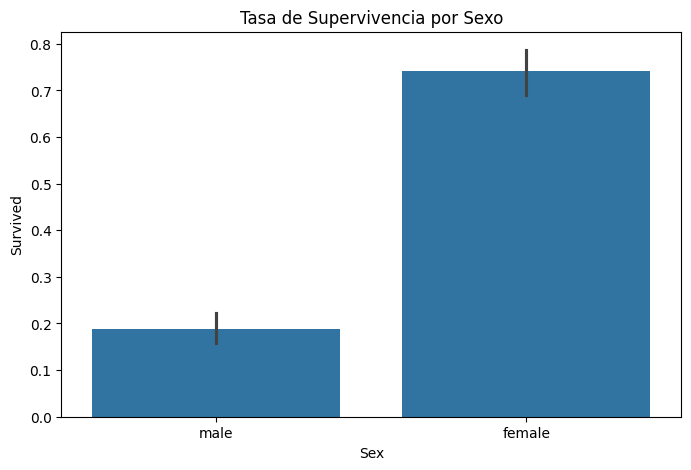

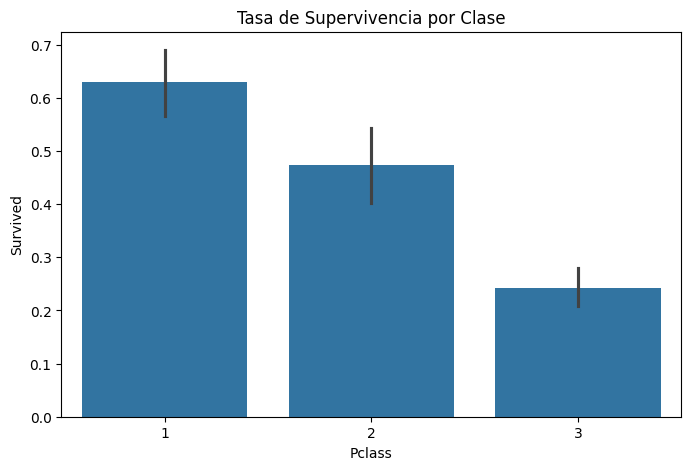

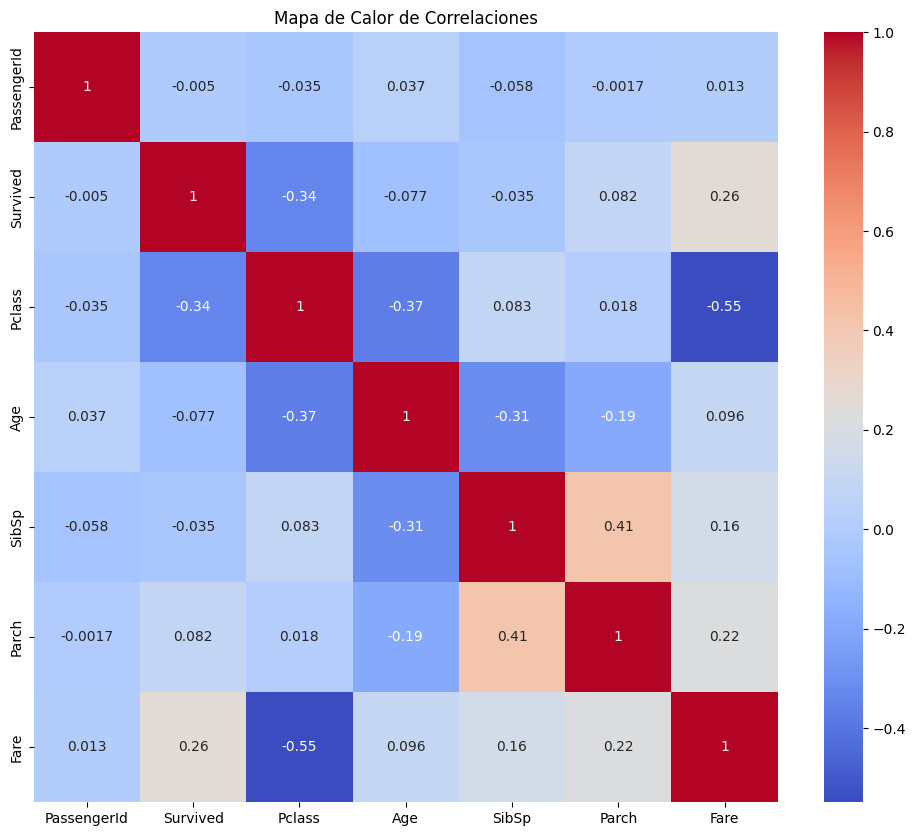

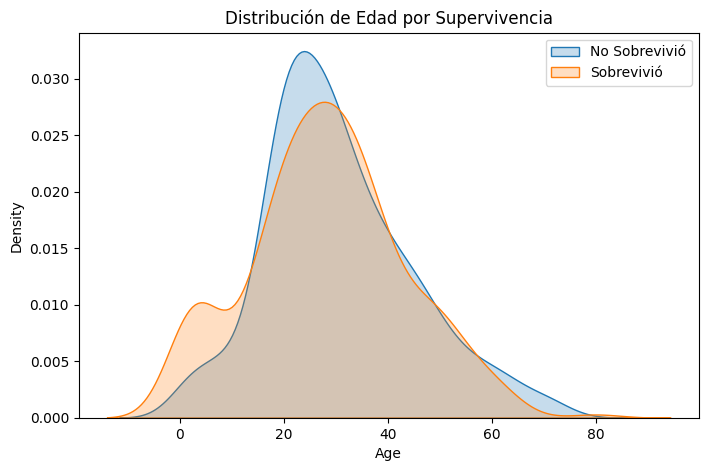

Regresión Logística - Precisión promedio CV: 0.8258
KNN - Precisión promedio CV: 0.8034
Árbol de Decisión - Precisión promedio CV: 0.7472
XGBoost - Precisión promedio CV: 0.7865
[LightGBM] [Info] Number of positive: 214, number of negative: 355
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376098 -> initscore=-0.506142
[LightGBM] [Info] Start training from score -0.506142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [4]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para preprocesamiento y modelado
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# Ignorar advertencias para mantener el código limpio
import warnings
warnings.filterwarnings('ignore')

# Paso 1: Carga y Exploración Inicial de Datos
train_data = pd.read_csv("C:/Users/ivan_/Documents/bootcamp/machine_learning/core08/train.csv")
test_data = pd.read_csv("C:/Users/ivan_/Documents/bootcamp/machine_learning/core08/test.csv")

print("Resumen del conjunto de entrenamiento:")
print(train_data.info())

print("\nValores faltantes en el conjunto de entrenamiento:")
print(train_data.isnull().sum())

def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = df[(df[column] < limite_inferior) | (df[column] > limite_superior)]
    return outliers, limite_inferior, limite_superior

outliers_fare, _, _ = detect_outliers(train_data, 'Fare')
outliers_age, _, _ = detect_outliers(train_data, 'Age')

print("\nOutliers detectados en Fare:", len(outliers_fare))
print("Outliers detectados en Age:", len(outliers_age))

# Paso 2: EDA
print("\nResumen Estadístico:")
print(train_data.describe(include='all'))

plt.figure(figsize=(8,5))
sns.barplot(x='Sex', y='Survived', data=train_data)
plt.title('Tasa de Supervivencia por Sexo')
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x='Pclass', y='Survived', data=train_data)
plt.title('Tasa de Supervivencia por Clase')
plt.show()

# Filtrar solo columnas numéricas para calcular la correlación
numeric_cols = train_data.select_dtypes(include=[np.number])

# Generar el mapa de calor
plt.figure(figsize=(12,10))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de Calor de Correlaciones')
plt.show()

plt.figure(figsize=(8,5))
sns.kdeplot(train_data[train_data['Survived']==0]['Age'], shade=True, label='No Sobrevivió')
sns.kdeplot(train_data[train_data['Survived']==1]['Age'], shade=True, label='Sobrevivió')
plt.title('Distribución de Edad por Supervivencia')
plt.legend()
plt.show()

# Paso 3: Preprocesamiento de Datos
import re

def extract_title(name):
    titulo_busqueda = re.search(' ([A-Za-z]+)\.', name)
    if titulo_busqueda:
        return titulo_busqueda.group(1)
    return ""

train_data['Title'] = train_data['Name'].apply(extract_title)
test_data['Title'] = test_data['Name'].apply(extract_title)

title_mapping = {
    "Capt": "Rare", "Col": "Rare", "Don": "Rare", "Dr": "Rare", "Major": "Rare", "Rev": "Rare",
    "Sir": "Rare", "Jonkheer": "Rare", "Dona": "Rare", "Lady": "Rare", "Countess": "Rare",
    "Mme": "Mrs", "Mlle": "Miss", "Ms": "Miss"
}
train_data['Title'] = train_data['Title'].replace(title_mapping)
test_data['Title'] = test_data['Title'].replace(title_mapping)

train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1

train_data['IsAlone'] = (train_data['FamilySize'] == 1).astype(int)
test_data['IsAlone'] = (test_data['FamilySize'] == 1).astype(int)

train_data['Age'].fillna(train_data.groupby('Title')['Age'].transform('median'), inplace=True)
test_data['Age'].fillna(test_data.groupby('Title')['Age'].transform('median'), inplace=True)

test_data['Fare'].fillna(test_data['Fare'].median(), inplace=True)
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)

columnas_eliminar = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch']
train_data.drop(columns=columnas_eliminar, inplace=True)
test_data.drop(columns=columnas_eliminar, inplace=True)

caracteristicas_categoricas = ['Embarked', 'Title']
train_data = pd.get_dummies(train_data, columns=caracteristicas_categoricas, drop_first=True)
test_data = pd.get_dummies(test_data, columns=caracteristicas_categoricas, drop_first=True)

le = LabelEncoder()
train_data['Sex'] = le.fit_transform(train_data['Sex'])
test_data['Sex'] = le.transform(test_data['Sex'])

train_data, test_data = train_data.align(test_data, join='left', axis=1, fill_value=0)

scaler = StandardScaler()
caracteristicas_numericas = ['Age', 'Fare', 'FamilySize']
train_data[caracteristicas_numericas] = scaler.fit_transform(train_data[caracteristicas_numericas])
test_data[caracteristicas_numericas] = scaler.transform(test_data[caracteristicas_numericas])

X = train_data.drop('Survived', axis=1)
y = train_data['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Paso 4: Implementación de Modelos y Benchmark
models = {
    "Regresión Logística": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Árbol de Decisión": DecisionTreeClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    results[name] = scores.mean()
    print(f"{name} - Precisión promedio CV: {scores.mean():.4f}")

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': range(3, 10, 2),
    'learning_rate': [0.01, 0.1, 0.2]
}
grid_xgb = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid_xgb,
    cv=5,
    scoring='accuracy'
)
grid_xgb.fit(X_train, y_train)
print("\nMejores parámetros para XGBoost:", grid_xgb.best_params_)

best_xgb = XGBClassifier(
    use_label_encoder=False, eval_metric='logloss',
    n_estimators=grid_xgb.best_params_['n_estimators'],
    max_depth=grid_xgb.best_params_['max_depth'],
    learning_rate=grid_xgb.best_params_['learning_rate'],
    random_state=42
)
best_xgb.fit(X_train, y_train)

y_pred = best_xgb.predict(X_val)
print("\nReporte de clasificación (XGBoost):")
print(classification_report(y_val, y_pred))

voting_clf = VotingClassifier(
    estimators=[
        ('xgb', best_xgb),
        ('lr', LogisticRegression(max_iter=1000))
    ],
    voting='hard'
)
voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_val)
print("\nReporte de clasificación (Voting Classifier):")
print(classification_report(y_val, y_pred_voting))

# **Alineación de las columnas del conjunto de prueba**
test_data = test_data[X.columns]

# Predicciones finales en el conjunto de prueba
test_predictions = voting_clf.predict(test_data)
submission = pd.DataFrame({
    'PassengerId': pd.read_csv("C:/Users/ivan_/Documents/bootcamp/machine_learning/core08/test.csv")['PassengerId'],
    'Survived': test_predictions
})

# Guardar el archivo de salida
# submission.to_csv('submission.csv', index=False)
